In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df=pd.read_excel("data_sdgs and non_final.xlsx")

C:\Users\daian\anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
train, test= train_test_split(df,test_size=0.1, random_state=0)

In [4]:
train.shape

(1923, 3)

In [5]:
#convert to list
data=train.Long_description.values.tolist()

In [6]:
#tokenize and clean-up using gensim simple_preprocess()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['curiositystream', 'is', 'global', 'factual', 'streaming', 'services', 'and', 'media', 'companies', 'our', 'documentary', 'series', 'and', 'features', 'cover', 'every', 'topic', 'from', 'space', 'exploration', 'to', 'adventure', 'to', 'the', 'secret', 'life', 'of', 'pets', 'empowering', 'viewers', 'of', 'all', 'ages', 'to', 'fuel', 'their', 'passions', 'and', 'explore', 'new', 'ones', 'with', 'thousands', 'of', 'titles', 'many', 'in', 'ultra', 'hd', 'including', 'exclusive', 'originals', 'curiositystream', 'features', 'stunning', 'visuals', 'and', 'unrivaled', 'storytelling', 'to', 'demystify', 'science', 'nature', 'history', 'technology', 'society', 'and', 'lifestyle', 'curiositystream', 'programming', 'is', 'available', 'worldwide', 'to', 'watch', 'on', 'tv', 'desktop', 'mobile', 'and', 'tablets', 'find', 'us', 'on', 'roku', 'apple', 'tv', 'channels', 'and', 'apple', 'tv', 'xbox', 'one', 'amazon', 'fire', 'tv', 'google', 'chromecast', 'ios', 'and', 'android', 'as', 'well', 'as', 'a

In [7]:
#lemmatization - convert words to its root word

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
# Initialize spacy 'en' model

nlp = spacy.load('en_core_web_sm')

In [9]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['curiositystream global factual streaming service medium company documentary series feature cover topic space exploration adventure secret life pet empower viewer age fuel passion explore new one thousand title many ultra hd include exclusive original curiositystream feature stunning visual unrivaled storytelling demystify science nature history technology society lifestyle curiositystream programming be available worldwide watch tv desktop mobile tablet find roku apple tv channel apple tv xbox amazon fire tv google chromecast io android as well amazon prime video channel youtube tv sling tv dish comcast xfinity demand cox communication altice usa suddenlink mobile frndly tv vidgo sony samsung vizio smart tvs liberty global com hem multichoice starhub tv totalplay millicom okko gazprom other global distribution partner platform', 'factorial human resource software platform small medium company integrate vacation management payroll document management benefit employee automate company 

In [10]:
#create the document word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum  occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [11]:
#check sparcity - the percentge of non zero datapoints in the document word matrix 

data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.1372810505930055 %


In [12]:
#build lda model with skleran

lda_model = LatentDirichletAllocation(n_components=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                     # n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [13]:
#diagnose model perfromance with perplexity and log likelihood
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -383278.4974961286
Perplexity:  651.750733398495
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': None,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [14]:
# Define Search Param
search_params = {'n_components': [2,3,4], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\daian\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\daian\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\daian\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:11

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [2, 3, 4], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 2}
Best Log Likelihood Score:  -131337.9106221811
Model Perplexity:  653.5746119011932


<>:21: DeprecationWarning: invalid escape sequence \O
<>:21: DeprecationWarning: invalid escape sequence \O
<>:21: DeprecationWarning: invalid escape sequence \O
<ipython-input-40-8f51e096bcf1>:21: DeprecationWarning: invalid escape sequence \O
  plt.savefig('graphs\OPTIMALSDGSANDNON_'+'.png')


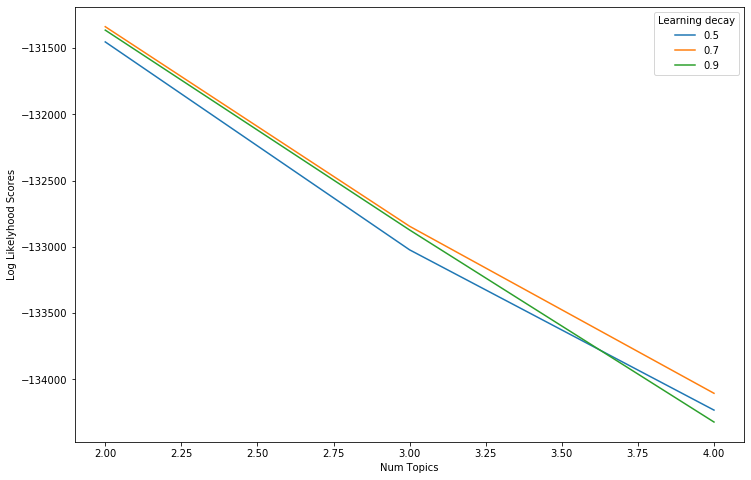

In [40]:
# Get Log Likelyhoods from Grid Search Output

from sklearn.model_selection import GridSearchCV
n_topics = [2,3,4]
#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
#plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
#plt.show()
plt.savefig('graphs\OPTIMALSDGSANDNON_'+'.png')

In [17]:
#see dominant topic in each document
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

In [18]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.980000,0.020000,0
Doc1,0.020000,0.980000,1
Doc2,0.020000,0.980000,1
Doc3,0.060000,0.940000,1
Doc4,0.270000,0.730000,1
Doc5,0.680000,0.320000,0
Doc6,0.250000,0.750000,1
Doc7,0.330000,0.670000,1
Doc8,0.770000,0.230000,0
Doc9,0.100000,0.900000,1


In [19]:
train.head(15)

,Company Name,Long_description,Type
1949,CuriosityStream,CuriosityStream is a global factual streaming ...,non_SDGs
1583,Factorial,Factorial is a human resources software platfo...,non_SDGs
2060,Apptio,Apptio is the leading provider of cloud-based ...,non_SDGs
342,SKOUT Cybersecurity,SKOUT Cybersecurity is a channel-only provider...,SDGs
1833,Grip Invest,Grip is an investment platform that allows ret...,non_SDGs
1577,ExecOnline,ExecOnline delivers transformational learning ...,non_SDGs
98,ftcash,ftcash is a fast growing financial technology ...,SDGs
2092,Truepill,Truepill is a B2B pharmacy fulfillment service...,non_SDGs
726,Aashiyaan Housing and Development Finance,Provide housing finance to those in the inform...,SDGs
303,AppDynamics,Cisco AppDynamics is on a mission to help the ...,SDGs


In [20]:
df_document_topics.to_excel("df_document_topicsfinal.xlsx")

In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,977
1,1,946


In [22]:
df_topic_distribution.to_excel("df_topic_distributionfinal.xlsx")

In [24]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\daian\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\daian\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\daian\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:347: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe.

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  52.880224
0      60.312561 -141.369141       2        1  47.119776, topic_info=          Term        Freq       Total Category  logprob  loglift
274      datum  409.000000  409.000000  Default  30.0000  30.0000
128   business  606.000000  606.000000  Default  29.0000  29.0000
504     health  266.000000  266.000000  Default  28.0000  28.0000
427  financial  356.000000  356.000000  Default  27.0000  27.0000
775     people  287.000000  287.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
264   customer  182.453026  485.095714   Topic2  -5.0289  -0.2254
723        new  145.090110  291.116836   Topic2  -5.2580   0.0561
285    deliver  133.973365  243.883076   Topic2  -5.3377   0.1534
6       access  131.325583  265.647771   Topic2  -5.3577   0.0480
362     enable  132.045018  352.537264   Topic2  -5.3522  -0.2295

[174 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6         1  0.504427      access
6         2  0.493134      access
8         1  0.976893     account
8         2  0.036181     account
34        1  0.081046  affordable
...     ...       ...         ...
1158      2  0.574747        work
1160      1  0.986337    workflow
1160      2  0.026658    workflow
1163      1  0.448189       world
1163      2  0.552074       world

[264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,academic,accel,accelerate,accept,access,accessible,account,accounting,...,workforce,workplace,world,worldwide,write,www,year,yield,york,young
Topic0,9.412229,37.445884,11.179274,0.601462,4.182699,11.936883,134.97794,46.494239,1.569955,0.540577,...,7.536807,18.389984,191.555912,24.641535,7.888219,19.857398,46.494542,18.241614,36.72892,19.457856
Topic1,35.587771,1.554116,5.820726,10.398538,52.817301,3.063117,136.02206,17.505761,54.430045,18.459423,...,15.463193,0.610016,152.444088,28.358465,7.111781,23.142602,48.505458,0.758386,52.27108,0.542144


In [26]:
df_topic_keywords.to_excel("df_topic_keywordsfinal.xlsx")

In [27]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=17)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16
Topic 0,company,platform,provide,service,product,health,people,make,help,technology,offer,online,base,use,world,create,customer
Topic 1,company,business,platform,technology,datum,service,provide,financial,solution,customer,help,use,software,build,enable,base,digital


In [28]:
df_topic_keywords.to_excel("top17 wordsfinal.xlsx")

In [29]:
data_test=test.Long_description.values.tolist()

In [30]:
test.head()

,Company Name,Long_description,Type
810,Metaweb Technologies,Metaweb Technologies was spun out of Applied M...,SDGs
1785,Mark43,Mark43 creates the next generation of law enfo...,non_SDGs
2108,Instructure,Instructure is a technology company that is fo...,non_SDGs
2099,Trulioo,Trulioo operates a Digital Identity Network th...,non_SDGs
1638,Somatus,Somatus is a healthcare company that partners ...,non_SDGs


In [41]:
num=0
unseen_document = data_test[num]
print(unseen_document)

Metaweb Technologies was spun out of Applied Minds in July 2005 to build a better infrastructure for the Web. After several years of development, we recently launched our first product: Freebase – an open, shared database of the world's information. Freebase is an open database of the world’s information. It is built by the community and for the community — free for anyone to query, contribute to, built applications on top of, or integrate into their websites.


In [44]:
data_test[0:2]

["Metaweb Technologies was spun out of Applied Minds in July 2005 to build a better infrastructure for the Web. After several years of development, we recently launched our first product: Freebase – an open, shared database of the world's information. Freebase is an open database of the world’s information. It is built by the community and for the community — free for anyone to query, contribute to, built applications on top of, or integrate into their websites.",
 'Mark43 creates the next generation of law enforcement software that allows police to effortlessly collect, manage, analyze, and share information. It is on a mission to empower communities and their governments with new technologies that improve the safety and quality of life for all. Its intuitive software delivers cloud-first technology and data-driven insights to public safety. The company was founded in 2012 and is based in New York City.']

In [43]:
#predict topic for a new piece of text
# Define function to predict topic for a given text document.

nlp = spacy.load('en_core_web_sm')

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = unseen_document
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 0

['company', 'platform', 'provide', 'service', 'product', 'health', 'people', 'make', 'help', 'technology', 'offer', 'online', 'base', 'use', 'world', 'create', 'customer']


In [34]:
data_test=test.Long_description.values.tolist()

In [35]:
data_words = list(sent_to_words(data_test))

In [36]:
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['metaweb technology spin apply mind july build well infrastructure web several year development recently launch first product freebase open share database world information freebase be open database world information build community community free query contribute build application top integrate website', 'mark create next generation law enforcement software allow police effortlessly collect manage analyze share information mission empower community government new technology improve safety quality life intuitive software deliver cloud first technology datum drive insight public safety company found base new york city']


In [37]:
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [38]:
lda_output = best_lda_model.fit_transform(data_vectorized)

In [39]:
#diagnose model perfromance with perplexity and log likelihood
# Log Likelyhood: Higher the better
print("Log Likelihood: ", best_lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", best_lda_model.perplexity(data_vectorized))

Log Likelihood:  -14865.65897168099
Perplexity:  113.95396049617587
